In [141]:
# Importaciones básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import os
from tqdm import tqdm

# Importaciones de darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler

# Importar el StandardScaler() para normalizar los datos de un pandas dataframe

# Métricas de scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Para optimización de hiperparámetros
import optuna
import traceback

# TimesFM y sus dependencias
from gluonts.dataset.pandas import PandasDataset

from uni2ts.model.moirai import MoiraiForecast, MoiraiModule


# Configuración de logging
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)

In [142]:
# 2. Cargar datos
df = pd.read_csv("monthly_data.csv")
df["DATES"] = pd.to_datetime(df["DATES"])
df.set_index("DATES", inplace=True)
df = df.dropna()

C:\Users\Carlos Palma\AppData\Local\Temp\ipykernel_71160\2981608354.py:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['DATES'] = pd.to_datetime(df['DATES'])


In [143]:
def calculate_directional_accuracy(y_true, y_pred, method="returns"):
    """
    Calcula la precisión direccional usando diferentes métodos

    :param y_true: Valores reales
    :param y_pred: Valores predichos
    :param method: 'returns' o 'differences'
    :return: (accuracy, accuracy_string)
    """
    # Asegurarse de que y_true e y_pred son arrays de numpy
    if isinstance(y_true, pd.Series):
        y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.to_numpy()

    # Aplanar los arrays si tienen más de una dimensión
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Asegurarse de que y_true y y_pred tienen la misma longitud
    if len(y_true) != len(y_pred):
        min_len = min(len(y_true), len(y_pred))
        y_true = y_true[:min_len]
        y_pred = y_pred[:min_len]

    if method == "returns":
        # Calcular retornos, excluyendo el primer valor
        true_returns = np.diff(y_true) / y_true[:-1]
        pred_returns = np.diff(y_pred) / y_pred[:-1]

    elif method == "differences":
        # Usar diferencias simples
        true_returns = np.diff(y_true)
        pred_returns = np.diff(y_pred)
    else:
        raise ValueError("El parámetro 'method' debe ser 'returns' o 'differences'")

    # Calcular la dirección del movimiento (1 para subida, -1 para bajada, 0 para sin cambio)
    true_direction = np.sign(true_returns)
    pred_direction = np.sign(pred_returns)

    # Filtrar los movimientos válidos (excluyendo casos donde no hubo cambio real)
    valid_indices = true_direction != 0
    true_direction = true_direction[valid_indices]
    pred_direction = pred_direction[valid_indices]

    # Validar si hay movimientos válidos
    if len(true_direction) == 0:
        # Si no hay movimientos válidos, la precisión direccional no se puede calcular
        accuracy = 0.0
        accuracy_string = "Directional Accuracy = No valid movements to evaluate"
    else:
        # Calcular la precisión comparando direcciones reales y predichas
        correct_predictions = np.sum(true_direction == pred_direction)
        accuracy = correct_predictions / len(true_direction)

        accuracy_percentage = accuracy * 100
        accuracy_string = f"Directional Accuracy = {accuracy_percentage:.2f}%"

    return accuracy, accuracy_string

In [144]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[["PEN"]])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Funciones Auxiliares

In [145]:
# Funciones auxiliares que necesitaremos
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}


def save_hyperparameters(params, model_name):
    filename = f"best_hyperparameters_{model_name}.json"
    with open(filename, "w") as f:
        json.dump(params, f)
    print(f"Hiperparámetros guardados en {filename}")


def load_hyperparameters(model_name):
    filename = f"best_hyperparameters_{model_name}.json"
    try:
        with open(filename, "r") as f:
            return json.load(f)
    except FileNotFoundError:
        return None


def save_model(model, model_name):
    filename = f"{model_name}_hyperparams.json"
    # En lugar de guardar el modelo completo, guardamos sus hiperparámetros
    model_params = {
        "prediction_length": model.prediction_length,
        "context_length": model.context_length,
        "patch_size": model.patch_size,
        "num_samples": model.num_samples,
        "target_dim": model.target_dim,
        "feat_dynamic_real_dim": model.feat_dynamic_real_dim,
        "past_feat_dynamic_real_dim": model.past_feat_dynamic_real_dim,
    }
    with open(filename, "w") as f:
        json.dump(model_params, f)
    print(f"Hiperparámetros del modelo guardados en {filename}")


def load_model(model_name, module):
    filename = f"{model_name}_hyperparams.json"
    try:
        with open(filename, "r") as f:
            params = json.load(f)
            # Recrear el modelo con los parámetros guardados
            model = MoiraiForecast(module=module, **params)
            return model
    except FileNotFoundError:
        return None


# Funciones para la estrategia de trading


# Transform the serie en returns
def return_series(series):
    if not isinstance(series, pd.Series):
        raise TypeError(
            "La serie debe ser un objeto de tipo pandas.Series para calcular los retornos."
        )
    return series.pct_change().dropna()


def implement_trading_strategy(real_returns, predicted_returns):
    if isinstance(real_returns, np.ndarray):
        real_returns_pd = pd.Series(real_returns)
    elif isinstance(real_returns, pd.Series):
        real_returns_pd = real_returns
    else:
        raise ValueError("real_returns must be either numpy array or pandas Series.")

    if isinstance(predicted_returns, np.ndarray):
        predicted_returns_pd = pd.Series(predicted_returns)
    elif isinstance(predicted_returns, pd.Series):
        predicted_returns_pd = predicted_returns
    else:
        raise ValueError(
            "predicted_returns must be either numpy array or pandas Series."
        )

    # Create the position and calculate strategy returns
    position = pd.Series(
        np.where(predicted_returns_pd > 0, 1, -1), index=predicted_returns_pd.index
    )
    strategy_returns = real_returns_pd * position.shift(1)

    return strategy_returns


def calculate_cumulative_return(returns):
    return (1 + returns).cumprod() - 1


def calculate_performance_metrics(pred_returns, benchmark_returns=None):
    # Asegurar que los inputs sean pandas.Series
    if not isinstance(pred_returns, pd.Series):
        pred_returns = pd.Series(pred_returns)

    # Crear un benchmark de ceros si no se proporciona uno
    if benchmark_returns is None:
        benchmark_returns = pd.Series([0] * len(pred_returns), index=pred_returns.index)
    elif not isinstance(benchmark_returns, pd.Series):
        benchmark_returns = pd.Series(benchmark_returns)

    # Retornos totales y anualizados
    total_return = (1 + pred_returns).prod() - 1
    annualized_return = (1 + total_return) ** (12 / len(pred_returns)) - 1

    # Sharpe Ratio (sin tasa libre de riesgo)
    sharpe_ratio = np.sqrt(12) * pred_returns.mean() / pred_returns.std()

    # Exceso de retornos para Information Ratio
    excess_returns = pred_returns - benchmark_returns
    tracking_error = excess_returns.std()
    information_ratio = excess_returns.mean() / tracking_error

    # Máximo Drawdown
    cumulative_returns = (1 + pred_returns).cumprod()
    peak = cumulative_returns.cummax()
    max_drawdown = ((cumulative_returns / peak) - 1).min()

    return {
        "Total Return": total_return,
        "Annualized Return": annualized_return,
        "Sharpe Ratio": sharpe_ratio,
        "Information Ratio": information_ratio,
        "Max Drawdown": max_drawdown,
    }


def calculate_hit_ratio(y_pred, y_true=None):
    """
    Calcula el Hit Ratio entre los valores reales y predichos.

    :param y_true: Array o Series con los valores reales, usa y_pred como y_true si no se proporciona
    :param y_pred: Array o Series con los valores predichos
    :return: Tupla con (hit_ratio, hit_ratio_string)

    Si y_true no se proporciona, se calculará el hit ratio de y_pred contra sí mismo.
    """
    if y_true is None:
        y_true = y_pred
    if isinstance(y_true, pd.Series):
        y_true = y_true.to_numpy()
    if isinstance(y_pred, pd.Series):
        y_pred = y_pred.to_numpy()

    if len(y_pred) != len(y_true):
        raise ValueError("y_pred and y_true must have the same length.")

    same_sign_count = np.sum(np.sign(y_pred) == np.sign(y_true))
    hit_ratio = same_sign_count / len(y_true) * 100

    hit_ratio_string = f"Hit Ratio = {hit_ratio:.2f}%"

    return hit_ratio, hit_ratio_string


# Función para calcular todas las métricas incluyendo Hit Ratio
def calculate_all_metrics(pred_returns, real_returns=None):
    performance_metrics = calculate_performance_metrics(pred_returns, real_returns)
    hit_ratio, hit_ratio_string = calculate_hit_ratio(pred_returns, real_returns)

    all_metrics = {
        **performance_metrics,
        "Hit Ratio": hit_ratio,
    }

    return all_metrics


def evaluate_model_performance(y_true, y_pred, model_name, retrain=False):
    # Handle Darts TimeSeries objects
    if isinstance(y_true, TimeSeries):
        y_true = y_true.values()  # Convert to NumPy array
    if isinstance(y_pred, TimeSeries):
        y_pred = y_pred.values()  # Convert to NumPy array

    # Ensure y_true and y_pred are numpy arrays or pandas Series
    if not isinstance(y_true, (np.ndarray, pd.Series)):
        raise TypeError(
            f"y_true debe ser un numpy.ndarray, pandas.Series o Darts TimeSeries, pero se recibió {type(y_true)}"
        )
    if not isinstance(y_pred, (np.ndarray, pd.Series)):
        raise TypeError(
            f"y_pred debe ser un numpy.ndarray, pandas.Series o Darts TimeSeries, pero se recibió {type(y_pred)}"
        )

    # Convert to numpy array if it's a pandas Series
    y_true_np = y_true.values if isinstance(y_true, pd.Series) else y_true
    y_pred_np = y_pred.values if isinstance(y_pred, pd.Series) else y_pred

    # Error metrics calculation
    mse = mean_squared_error(y_true_np, y_pred_np)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_np, y_pred_np)
    r2 = r2_score(y_true_np, y_pred_np)

    error_metrics = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R2": r2}

    # Convert to pandas Series for return calculations
    y_true_series = (
        pd.Series(y_true.flatten()) if isinstance(y_true, np.ndarray) else y_true
    )
    y_pred_series = (
        pd.Series(y_pred.flatten()) if isinstance(y_pred, np.ndarray) else y_pred
    )

    # Ensure they are Series before calculating returns
    try:
        y_true_returns = return_series(y_true_series)
        y_pred_returns = return_series(y_pred_series)
    except TypeError as e:
        print(f"Error: {e}")
        return None, None

    # Implement trading strategy
    strategy_returns = implement_trading_strategy(y_true_returns, y_pred_returns)

    # Calculate performance metrics
    performance_metrics = calculate_performance_metrics(
        strategy_returns, y_true_returns
    )

    # Calculate Hit Ratio
    hit_ratio, hit_ratio_string = calculate_hit_ratio(strategy_returns, y_true_returns)

    # Combine all metrics
    all_metrics = {
        "Model": model_name,
        "Retrain": retrain,
        **error_metrics,
        **performance_metrics,
        "Hit Ratio": hit_ratio,
    }

    return all_metrics, strategy_returns

# MODELO MOIRAI

In [146]:
def prepare_moirai_data(timeseries: TimeSeries) -> PandasDataset:
    """
    Prepara los datos en el formato que espera MOIRAI
    """
    # Convertir TimeSeries a DataFrame
    df = timeseries.pd_dataframe()

    # Resetear el índice para tener la columna de fechas explícita
    df = df.reset_index()

    # Renombrar la columna del índice temporal si es necesario
    if "index" in df.columns:
        df = df.rename(columns={"index": "timestamp"})
    elif "DATES" in df.columns:
        df = df.rename(columns={"DATES": "timestamp"})

    # Asegurarse que la columna temporal es datetime
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Crear el dataset de GluonTS
    dataset = PandasDataset(df, target="PEN", timestamp="timestamp", freq="M")

    return dataset

In [ ]:
def optimize_moirai(train_data: TimeSeries, module: MoiraiModule):
    """Optimizar hiperparámetros usando Optuna"""

    def objective(trial):
        try:
            # Definir parámetros a optimizar
            params = {
                "prediction_length": trial.suggest_categorical(
                    "prediction_length", [1, 2, 3]
                ),  # Fijo para predicción paso a paso
                "context_length": trial.suggest_int("context_length", 30, 300),
                "patch_size": trial.suggest_categorical("patch_size", [8, 16, 32, 64]),
                "num_samples": trial.suggest_int("num_samples", 50, 300),
                "target_dim": 1,
                "feat_dynamic_real_dim": 0,
                "past_feat_dynamic_real_dim": 0,
            }

            print(f"[INFO] Trying parameters: {params}")

            # Crear modelo
            model = MoiraiForecast(module=module, **params)

            # Preparar datos para validación
            val_size = int(len(train_data) * 0.3)
            train_subset = train_data[:-val_size]
            val_subset = train_data[-val_size:]

            # Convertir datos al formato GluonTS
            train_dataset = prepare_moirai_data(train_subset)

            # Crear predictor
            predictor = model.create_predictor(batch_size=32)

            # Generar predicciones
            forecasts = list(predictor.predict(train_dataset))

            # Calcular error
            predictions = np.array([forecast.mean for forecast in forecasts])
            actual_values = val_subset.values().flatten()[: len(predictions)]

            mae_error = np.mean(np.abs(predictions - actual_values))
            # direction_score = calculate_directional_accuracy(actual_values, predictions, method='returns')[0]

            # Combinar métricas
            mae_normalized = mae_error / 0.1
            combined_error = mae_normalized  # + 0.6 * (1 - direction_score)

            # Guardar métricas
            trial.set_user_attr("mae_original", float(mae_error))
            # trial.set_user_attr('direction_accuracy', float(direction_score * 100))
            trial.set_user_attr("combined_score", float(combined_error))

            return combined_error

        except Exception as e:
            print(f"[ERROR] Error en trial: {str(e)}")
            traceback.print_exc()
            return float("inf")

    # Configurar optimización
    study = optuna.create_study(
        direction="minimize", sampler=optuna.samplers.TPESampler(seed=42)
    )

    def print_callback(study, trial):
        if trial.number % 2 == 0:
            print(f"\nTrial {trial.number}:")

            # Manejar MAE
            mae_value = trial.user_attrs.get("mae_original", None)
            if mae_value is not None:
                print(f"MAE: {mae_value:.6f}")
            else:
                print("MAE: N/A")

            # Manejar Direction Accuracy
            dir_acc = trial.user_attrs.get("direction_accuracy", None)
            if dir_acc is not None:
                print(f"Direction Accuracy: {dir_acc:.2f}%")
            else:
                print("Direction Accuracy: N/A")

            # Manejar Combined Score
            if trial.value != float("inf"):
                print(f"Combined Score: {trial.value:.3f}")
            else:
                print("Combined Score: N/A")

    # Optimizar
    study.optimize(objective, n_trials=50, callbacks=[print_callback])

    # Obtener mejores parámetros
    best_params = {
        "prediction_length": 1,
        "context_length": study.best_params["context_length"],
        "patch_size": study.best_params["patch_size"],
        "num_samples": study.best_params["num_samples"],
        "target_dim": 1,
        "feat_dynamic_real_dim": 0,
        "past_feat_dynamic_real_dim": 0,
    }

    return best_params

In [148]:
def step_by_step_forecast(model, train_data, test_data, retrain=False):
    """Realizar predicciones paso a paso"""
    forecast_filename = f"moirai_forecast_{'retrain' if retrain else 'no_retrain'}.pkl"

    if os.path.exists(forecast_filename):
        print(f"Cargando forecast guardado de {forecast_filename}")
        with open(forecast_filename, "rb") as f:
            return pickle.load(f)

    predictions = []
    current_train = train_data.copy()
    predictor = model.create_predictor(batch_size=32)

    for i in tqdm(range(len(test_data)), desc="Generando predicciones"):
        try:
            # Preparar datos para predicción
            current_dataset = prepare_moirai_data(current_train)

            # Generar predicción
            forecasts = list(predictor.predict(current_dataset))

            if forecasts:
                # Tomar la primera predicción (debería ser solo una)
                forecast = forecasts[0]
                pred = forecast.mean[-1]  # Tomar el último valor de la predicción
            else:
                raise ValueError("No se generaron predicciones")

            predictions.append(pred)

            # Actualizar serie de entrenamiento
            new_data = test_data[i : i + 1]
            current_train = current_train.append(new_data)

            if retrain and i % 10 == 0:  # Reentrenar cada 10 pasos
                predictor = model.create_predictor(batch_size=32)

        except Exception as e:
            print(f"Error en paso {i}: {str(e)}")
            if len(predictions) > 0:
                predictions.append(predictions[-1])
            else:
                predictions.append(float(current_train.values()[-1][0]))

    # Crear TimeSeries con predicciones
    forecast = TimeSeries.from_times_and_values(
        times=test_data.time_index, values=np.array(predictions).reshape(-1, 1)
    )

    # Guardar predicciones
    with open(forecast_filename, "wb") as f:
        pickle.dump(forecast, f)

    return forecast

In [149]:
def create_moirai_model(module, params=None):
    """Crear modelo MOIRAI con parámetros optimizados o por defecto"""
    if params is None:
        params = {
            "prediction_length": 1,
            "context_length": 200,
            "patch_size": 16,
            "num_samples": 100,
            "target_dim": 1,
            "feat_dynamic_real_dim": 0,
            "past_feat_dynamic_real_dim": 0,
        }

    model = MoiraiForecast(module=module, **params)
    return model

In [150]:
def train_moirai(train_data, module):
    """Entrenar modelo MOIRAI con optimización de hiperparámetros"""
    loaded_params = load_hyperparameters("moirai")
    if loaded_params is None:
        print("Optimizando hiperparámetros para MOIRAI...")
        best_params = optimize_moirai(train_data, module)
        save_hyperparameters(best_params, "moirai")
    else:
        print("Cargando hiperparámetros guardados para MOIRAI...")
        best_params = loaded_params

    model = MoiraiForecast(module=module, **best_params)

    return model, best_params

In [151]:
# Preprocesamiento de datos
series = TimeSeries.from_dataframe(df[["PEN"]])
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [152]:
# Configurar modelo base
SIZE = "base"
BSZ = 32
cache_dir = "./moirai_cache"

# Cargar módulo pre-entrenado
module = MoiraiModule.from_pretrained(
    f"Salesforce/moirai-1.0-R-{SIZE}", cache_dir=cache_dir
)

In [153]:
# Entrenar modelo Moirai
moirai_model, best_params = train_moirai(train_scaled, module)

[I 2024-11-27 18:17:40,843] A new study created in memory with name: no-name-b9af372d-6f99-40ab-9e36-ce9ed1ec1562


Optimizando hiperparámetros para MOIRAI...
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 192, 'patch_size': 64, 'num_samples': 200, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:41,197] Trial 0 finished with value: 0.06794256408542587 and parameters: {'prediction_length': 2, 'context_length': 192, 'patch_size': 64, 'num_samples': 200}. Best is trial 0 with value: 0.06794256408542587.
[I 2024-11-27 18:17:41,277] Trial 1 finished with value: 0.1148305094288767 and parameters: {'prediction_length': 3, 'context_length': 255, 'patch_size': 64, 'num_samples': 181}. Best is trial 0 with value: 0.06794256408542587.
[I 2024-11-27 18:17:41,339] Trial 2 finished with value: 0.09584116499095963 and parameters: {'prediction_length': 3, 'context_length': 67, 'patch_size': 64, 'num_samples': 100}. Best is trial 0 with value: 0.06794256408542587.
[I 2024-11-27 18:17:41,408] Trial 3 finished with value: 0.11166962544590042 and parameters: {'prediction_length': 2, 'context_length': 194, 'patch_size': 64, 'num_samples': 252}. Best is trial 0 with value: 0.06794256408542587.



Trial 0:
MAE: 0.006794
Direction Accuracy: 0.00%
Combined Score: 0.068
[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 255, 'patch_size': 64, 'num_samples': 181, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 67, 'patch_size': 64, 'num_samples': 100, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 2:
MAE: 0.009584
Direction Accuracy: 0.00%
Combined Score: 0.096
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 194, 'patch_size': 64, 'num_samples': 252, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:41,480] Trial 4 finished with value: 0.25588470260768936 and parameters: {'prediction_length': 3, 'context_length': 149, 'patch_size': 64, 'num_samples': 114}. Best is trial 0 with value: 0.06794256408542587.
[I 2024-11-27 18:17:41,564] Trial 5 finished with value: 3.409465427800713 and parameters: {'prediction_length': 1, 'context_length': 178, 'patch_size': 16, 'num_samples': 274}. Best is trial 0 with value: 0.06794256408542587.


[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 149, 'patch_size': 64, 'num_samples': 114, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 4:
MAE: 0.025588
Direction Accuracy: 0.00%
Combined Score: 0.256
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 178, 'patch_size': 16, 'num_samples': 274, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 83, 'patch_size': 32, 'num_samples': 258, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:41,636] Trial 6 finished with value: 0.06858217279583023 and parameters: {'prediction_length': 2, 'context_length': 83, 'patch_size': 32, 'num_samples': 258}. Best is trial 0 with value: 0.06794256408542587.
[I 2024-11-27 18:17:41,707] Trial 7 finished with value: 0.09239421142627731 and parameters: {'prediction_length': 3, 'context_length': 68, 'patch_size': 32, 'num_samples': 99}. Best is trial 0 with value: 0.06794256408542587.
[I 2024-11-27 18:17:41,795] Trial 8 finished with value: 2.46835457842022 and parameters: {'prediction_length': 2, 'context_length': 227, 'patch_size': 8, 'num_samples': 266}. Best is trial 0 with value: 0.06794256408542587.



Trial 6:
MAE: 0.006858
Direction Accuracy: 0.00%
Combined Score: 0.069
[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 68, 'patch_size': 32, 'num_samples': 99, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 227, 'patch_size': 8, 'num_samples': 266, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 8:
MAE: 0.246835
Direction Accuracy: 0.00%
Combined Score: 2.468
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 64, 'num_samples': 168, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:41,871] Trial 9 finished with value: 0.11060523550182388 and parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 64, 'num_samples': 168}. Best is trial 0 with value: 0.06794256408542587.
[I 2024-11-27 18:17:41,942] Trial 10 finished with value: 2.0992984132018666 and parameters: {'prediction_length': 2, 'context_length': 265, 'patch_size': 16, 'num_samples': 197}. Best is trial 0 with value: 0.06794256408542587.
[I 2024-11-27 18:17:42,016] Trial 11 finished with value: 0.07220355112880661 and parameters: {'prediction_length': 2, 'context_length': 122, 'patch_size': 32, 'num_samples': 223}. Best is trial 0 with value: 0.06794256408542587.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 265, 'patch_size': 16, 'num_samples': 197, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 10:
MAE: 0.209930
Direction Accuracy: 0.00%
Combined Score: 2.099
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 122, 'patch_size': 32, 'num_samples': 223, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 32, 'patch_size': 32, 'num_samples': 225, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:42,094] Trial 12 finished with value: 0.07495212118297623 and parameters: {'prediction_length': 2, 'context_length': 32, 'patch_size': 32, 'num_samples': 225}. Best is trial 0 with value: 0.06794256408542587.
[I 2024-11-27 18:17:42,170] Trial 13 finished with value: 2.590138490602074 and parameters: {'prediction_length': 2, 'context_length': 212, 'patch_size': 8, 'num_samples': 136}. Best is trial 0 with value: 0.06794256408542587.
[I 2024-11-27 18:17:42,254] Trial 14 finished with value: 0.059547747775612336 and parameters: {'prediction_length': 2, 'context_length': 138, 'patch_size': 32, 'num_samples': 289}. Best is trial 14 with value: 0.059547747775612336.



Trial 12:
MAE: 0.007495
Direction Accuracy: 0.00%
Combined Score: 0.075
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 212, 'patch_size': 8, 'num_samples': 136, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 138, 'patch_size': 32, 'num_samples': 289, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 14:
MAE: 0.005955
Direction Accuracy: 0.00%
Combined Score: 0.060
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 299, 'patch_size': 32, 'num_samples': 71, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:42,339] Trial 15 finished with value: 0.2849802629199605 and parameters: {'prediction_length': 2, 'context_length': 299, 'patch_size': 32, 'num_samples': 71}. Best is trial 14 with value: 0.059547747775612336.
[I 2024-11-27 18:17:42,445] Trial 16 finished with value: 3.705265398427544 and parameters: {'prediction_length': 1, 'context_length': 149, 'patch_size': 8, 'num_samples': 300}. Best is trial 14 with value: 0.059547747775612336.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 149, 'patch_size': 8, 'num_samples': 300, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 16:
MAE: 0.370527
Direction Accuracy: 0.00%
Combined Score: 3.705
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 119, 'patch_size': 16, 'num_samples': 154, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:42,550] Trial 17 finished with value: 2.819056983396111 and parameters: {'prediction_length': 2, 'context_length': 119, 'patch_size': 16, 'num_samples': 154}. Best is trial 14 with value: 0.059547747775612336.
[I 2024-11-27 18:17:42,646] Trial 18 finished with value: 0.0849004344192128 and parameters: {'prediction_length': 2, 'context_length': 167, 'patch_size': 32, 'num_samples': 300}. Best is trial 14 with value: 0.059547747775612336.
[I 2024-11-27 18:17:42,735] Trial 19 finished with value: 0.11359798471599625 and parameters: {'prediction_length': 1, 'context_length': 234, 'patch_size': 64, 'num_samples': 220}. Best is trial 14 with value: 0.059547747775612336.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 167, 'patch_size': 32, 'num_samples': 300, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 18:
MAE: 0.008490
Direction Accuracy: 0.00%
Combined Score: 0.085
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 234, 'patch_size': 64, 'num_samples': 220, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 191, 'patch_size': 32, 'num_samples': 199, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:42,830] Trial 20 finished with value: 0.10795625607639359 and parameters: {'prediction_length': 2, 'context_length': 191, 'patch_size': 32, 'num_samples': 199}. Best is trial 14 with value: 0.059547747775612336.
[I 2024-11-27 18:17:42,928] Trial 21 finished with value: 0.05611809651523636 and parameters: {'prediction_length': 2, 'context_length': 77, 'patch_size': 32, 'num_samples': 247}. Best is trial 21 with value: 0.05611809651523636.
[I 2024-11-27 18:17:43,022] Trial 22 finished with value: 0.018737316131591797 and parameters: {'prediction_length': 2, 'context_length': 87, 'patch_size': 32, 'num_samples': 241}. Best is trial 22 with value: 0.018737316131591797.



Trial 20:
MAE: 0.010796
Direction Accuracy: 0.00%
Combined Score: 0.108
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 77, 'patch_size': 32, 'num_samples': 247, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 87, 'patch_size': 32, 'num_samples': 241, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:43,116] Trial 23 finished with value: 0.05982354283332825 and parameters: {'prediction_length': 2, 'context_length': 91, 'patch_size': 32, 'num_samples': 242}. Best is trial 22 with value: 0.018737316131591797.
[I 2024-11-27 18:17:43,200] Trial 24 finished with value: 0.053937311574516755 and parameters: {'prediction_length': 2, 'context_length': 31, 'patch_size': 32, 'num_samples': 281}. Best is trial 22 with value: 0.018737316131591797.



Trial 22:
MAE: 0.001874
Direction Accuracy: 0.00%
Combined Score: 0.019
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 91, 'patch_size': 32, 'num_samples': 242, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 31, 'patch_size': 32, 'num_samples': 281, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 24:
MAE: 0.005394
Direction Accuracy: 0.00%
Combined Score: 0.054
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 31, 'patch_size': 32, 'num_samples': 241, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:43,304] Trial 25 finished with value: 0.06386640231281326 and parameters: {'prediction_length': 2, 'context_length': 31, 'patch_size': 32, 'num_samples': 241}. Best is trial 22 with value: 0.018737316131591797.
[I 2024-11-27 18:17:43,396] Trial 26 finished with value: 0.12231561104923294 and parameters: {'prediction_length': 2, 'context_length': 51, 'patch_size': 32, 'num_samples': 276}. Best is trial 22 with value: 0.018737316131591797.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 51, 'patch_size': 32, 'num_samples': 276, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 26:
MAE: 0.012232
Direction Accuracy: 0.00%
Combined Score: 0.122
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 97, 'patch_size': 32, 'num_samples': 239, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:43,524] Trial 27 finished with value: 0.0627608851638417 and parameters: {'prediction_length': 2, 'context_length': 97, 'patch_size': 32, 'num_samples': 239}. Best is trial 22 with value: 0.018737316131591797.
[I 2024-11-27 18:17:43,628] Trial 28 finished with value: 0.13102598548402197 and parameters: {'prediction_length': 3, 'context_length': 57, 'patch_size': 32, 'num_samples': 280}. Best is trial 22 with value: 0.018737316131591797.


[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 57, 'patch_size': 32, 'num_samples': 280, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 28:
MAE: 0.013103
Direction Accuracy: 0.00%
Combined Score: 0.131
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 41, 'patch_size': 32, 'num_samples': 210, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:43,727] Trial 29 finished with value: 0.14466094534069107 and parameters: {'prediction_length': 1, 'context_length': 41, 'patch_size': 32, 'num_samples': 210}. Best is trial 22 with value: 0.018737316131591797.
[I 2024-11-27 18:17:43,822] Trial 30 finished with value: 2.1858670071807484 and parameters: {'prediction_length': 2, 'context_length': 78, 'patch_size': 8, 'num_samples': 254}. Best is trial 22 with value: 0.018737316131591797.
[I 2024-11-27 18:17:43,911] Trial 31 finished with value: 0.008929669857025146 and parameters: {'prediction_length': 2, 'context_length': 138, 'patch_size': 32, 'num_samples': 286}. Best is trial 31 with value: 0.008929669857025146.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 78, 'patch_size': 8, 'num_samples': 254, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 30:
MAE: 0.218587
Direction Accuracy: 0.00%
Combined Score: 2.186
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 138, 'patch_size': 32, 'num_samples': 286, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 105, 'patch_size': 32, 'num_samples': 290, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:43,992] Trial 32 finished with value: 0.00878170132637024 and parameters: {'prediction_length': 2, 'context_length': 105, 'patch_size': 32, 'num_samples': 290}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:44,117] Trial 33 finished with value: 0.08574100892215775 and parameters: {'prediction_length': 2, 'context_length': 97, 'patch_size': 32, 'num_samples': 284}. Best is trial 32 with value: 0.00878170132637024.



Trial 32:
MAE: 0.000878
Direction Accuracy: 0.00%
Combined Score: 0.009
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 97, 'patch_size': 32, 'num_samples': 284, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 108, 'patch_size': 32, 'num_samples': 266, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:44,215] Trial 34 finished with value: 0.013880133628845215 and parameters: {'prediction_length': 2, 'context_length': 108, 'patch_size': 32, 'num_samples': 266}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:44,305] Trial 35 finished with value: 3.3382943030245085 and parameters: {'prediction_length': 3, 'context_length': 132, 'patch_size': 16, 'num_samples': 264}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:44,379] Trial 36 finished with value: 0.01154288649559021 and parameters: {'prediction_length': 2, 'context_length': 107, 'patch_size': 32, 'num_samples': 294}. Best is trial 32 with value: 0.00878170132637024.



Trial 34:
MAE: 0.001388
Direction Accuracy: 0.00%
Combined Score: 0.014
[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 132, 'patch_size': 16, 'num_samples': 264, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 107, 'patch_size': 32, 'num_samples': 294, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 36:
MAE: 0.001154
Direction Accuracy: 0.00%
Combined Score: 0.012
[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 105, 'patch_size': 32, 'num_samples': 299, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:44,458] Trial 37 finished with value: 0.04894025683869725 and parameters: {'prediction_length': 3, 'context_length': 105, 'patch_size': 32, 'num_samples': 299}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:44,527] Trial 38 finished with value: 0.2476702884879689 and parameters: {'prediction_length': 2, 'context_length': 145, 'patch_size': 64, 'num_samples': 292}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:44,606] Trial 39 finished with value: 0.011054575443267822 and parameters: {'prediction_length': 2, 'context_length': 159, 'patch_size': 32, 'num_samples': 265}. Best is trial 32 with value: 0.00878170132637024.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 145, 'patch_size': 64, 'num_samples': 292, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 38:
MAE: 0.024767
Direction Accuracy: 0.00%
Combined Score: 0.248
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 159, 'patch_size': 32, 'num_samples': 265, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 158, 'patch_size': 16, 'num_samples': 274, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:44,685] Trial 40 finished with value: 3.8220034794059377 and parameters: {'prediction_length': 1, 'context_length': 158, 'patch_size': 16, 'num_samples': 274}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:44,759] Trial 41 finished with value: 0.06392839114337967 and parameters: {'prediction_length': 2, 'context_length': 129, 'patch_size': 32, 'num_samples': 269}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:44,828] Trial 42 finished with value: 0.11845069687038468 and parameters: {'prediction_length': 2, 'context_length': 177, 'patch_size': 32, 'num_samples': 262}. Best is trial 32 with value: 0.00878170132637024.



Trial 40:
MAE: 0.382200
Direction Accuracy: 0.00%
Combined Score: 3.822
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 129, 'patch_size': 32, 'num_samples': 269, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 177, 'patch_size': 32, 'num_samples': 262, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 42:
MAE: 0.011845
Direction Accuracy: 0.00%
Combined Score: 0.118
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 110, 'patch_size': 32, 'num_samples': 289, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:44,906] Trial 43 finished with value: 0.0493447482585907 and parameters: {'prediction_length': 2, 'context_length': 110, 'patch_size': 32, 'num_samples': 289}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:45,009] Trial 44 finished with value: 0.038539792701302034 and parameters: {'prediction_length': 2, 'context_length': 161, 'patch_size': 32, 'num_samples': 254}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:45,101] Trial 45 finished with value: 0.0091347352710347 and parameters: {'prediction_length': 2, 'context_length': 109, 'patch_size': 32, 'num_samples': 182}. Best is trial 32 with value: 0.00878170132637024.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 161, 'patch_size': 32, 'num_samples': 254, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 44:
MAE: 0.003854
Direction Accuracy: 0.00%
Combined Score: 0.039
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 109, 'patch_size': 32, 'num_samples': 182, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:45,226] Trial 46 finished with value: 0.06988044434279139 and parameters: {'prediction_length': 3, 'context_length': 132, 'patch_size': 64, 'num_samples': 183}. Best is trial 32 with value: 0.00878170132637024.


[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 132, 'patch_size': 64, 'num_samples': 183, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 46:
MAE: 0.006988
Direction Accuracy: 0.00%
Combined Score: 0.070
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 67, 'patch_size': 8, 'num_samples': 105, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:45,333] Trial 47 finished with value: 1.8885182098594289 and parameters: {'prediction_length': 2, 'context_length': 67, 'patch_size': 8, 'num_samples': 105}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:45,444] Trial 48 finished with value: 0.10673898021846817 and parameters: {'prediction_length': 2, 'context_length': 147, 'patch_size': 32, 'num_samples': 81}. Best is trial 32 with value: 0.00878170132637024.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 147, 'patch_size': 32, 'num_samples': 81, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 48:
MAE: 0.010674
Direction Accuracy: 0.00%
Combined Score: 0.107
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 123, 'patch_size': 32, 'num_samples': 151, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:45,546] Trial 49 finished with value: 0.018716876104774016 and parameters: {'prediction_length': 2, 'context_length': 123, 'patch_size': 32, 'num_samples': 151}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:45,667] Trial 50 finished with value: 2.189970786973534 and parameters: {'prediction_length': 2, 'context_length': 195, 'patch_size': 16, 'num_samples': 53}. Best is trial 32 with value: 0.00878170132637024.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 195, 'patch_size': 16, 'num_samples': 53, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 50:
MAE: 0.218997
Direction Accuracy: 0.00%
Combined Score: 2.190
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 106, 'patch_size': 32, 'num_samples': 229, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:45,805] Trial 51 finished with value: 0.01372409303516342 and parameters: {'prediction_length': 2, 'context_length': 106, 'patch_size': 32, 'num_samples': 229}. Best is trial 32 with value: 0.00878170132637024.
[I 2024-11-27 18:17:45,897] Trial 52 finished with value: 0.046995456620750886 and parameters: {'prediction_length': 2, 'context_length': 101, 'patch_size': 32, 'num_samples': 231}. Best is trial 32 with value: 0.00878170132637024.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 101, 'patch_size': 32, 'num_samples': 231, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 52:
MAE: 0.004700
Direction Accuracy: 0.00%
Combined Score: 0.047
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 118, 'patch_size': 32, 'num_samples': 190, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:46,030] Trial 53 finished with value: 0.005098159715233308 and parameters: {'prediction_length': 2, 'context_length': 118, 'patch_size': 32, 'num_samples': 190}. Best is trial 53 with value: 0.005098159715233308.
[I 2024-11-27 18:17:46,128] Trial 54 finished with value: 0.01626429398387863 and parameters: {'prediction_length': 2, 'context_length': 121, 'patch_size': 32, 'num_samples': 174}. Best is trial 53 with value: 0.005098159715233308.
[I 2024-11-27 18:17:46,199] Trial 55 finished with value: 0.010697122022209626 and parameters: {'prediction_length': 1, 'context_length': 140, 'patch_size': 32, 'num_samples': 184}. Best is trial 53 with value: 0.005098159715233308.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 121, 'patch_size': 32, 'num_samples': 174, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 54:
MAE: 0.001626
Direction Accuracy: 0.00%
Combined Score: 0.016
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 140, 'patch_size': 32, 'num_samples': 184, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 170, 'patch_size': 8, 'num_samples': 188, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:46,283] Trial 56 finished with value: 3.4555392221656422 and parameters: {'prediction_length': 1, 'context_length': 170, 'patch_size': 8, 'num_samples': 188}. Best is trial 53 with value: 0.005098159715233308.
[I 2024-11-27 18:17:46,360] Trial 57 finished with value: 0.021208350256385344 and parameters: {'prediction_length': 1, 'context_length': 140, 'patch_size': 32, 'num_samples': 143}. Best is trial 53 with value: 0.005098159715233308.
[I 2024-11-27 18:17:46,442] Trial 58 finished with value: 0.25917845527797745 and parameters: {'prediction_length': 1, 'context_length': 157, 'patch_size': 64, 'num_samples': 165}. Best is trial 53 with value: 0.005098159715233308.



Trial 56:
MAE: 0.345554
Direction Accuracy: 0.00%
Combined Score: 3.456
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 140, 'patch_size': 32, 'num_samples': 143, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 157, 'patch_size': 64, 'num_samples': 165, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 58:
MAE: 0.025918
Direction Accuracy: 0.00%
Combined Score: 0.259
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 188, 'patch_size': 32, 'num_samples': 125, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:46,517] Trial 59 finished with value: 0.1151399568763356 and parameters: {'prediction_length': 1, 'context_length': 188, 'patch_size': 32, 'num_samples': 125}. Best is trial 53 with value: 0.005098159715233308.
[I 2024-11-27 18:17:46,591] Trial 60 finished with value: 0.005271260336341399 and parameters: {'prediction_length': 1, 'context_length': 120, 'patch_size': 32, 'num_samples': 210}. Best is trial 53 with value: 0.005098159715233308.
[I 2024-11-27 18:17:46,662] Trial 61 finished with value: 0.02376663248210953 and parameters: {'prediction_length': 1, 'context_length': 138, 'patch_size': 32, 'num_samples': 205}. Best is trial 53 with value: 0.005098159715233308.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 120, 'patch_size': 32, 'num_samples': 210, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 60:
MAE: 0.000527
Direction Accuracy: 0.00%
Combined Score: 0.005
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 138, 'patch_size': 32, 'num_samples': 205, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 117, 'patch_size': 32, 'num_samples': 192, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:46,734] Trial 62 finished with value: 0.0016792372909169018 and parameters: {'prediction_length': 1, 'context_length': 117, 'patch_size': 32, 'num_samples': 192}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:46,810] Trial 63 finished with value: 0.014167849615516204 and parameters: {'prediction_length': 1, 'context_length': 116, 'patch_size': 32, 'num_samples': 190}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:46,910] Trial 64 finished with value: 0.012881632253227693 and parameters: {'prediction_length': 1, 'context_length': 87, 'patch_size': 32, 'num_samples': 211}. Best is trial 62 with value: 0.0016792372909169018.



Trial 62:
MAE: 0.000168
Direction Accuracy: 0.00%
Combined Score: 0.002
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 116, 'patch_size': 32, 'num_samples': 190, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 87, 'patch_size': 32, 'num_samples': 211, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 64:
MAE: 0.001288
Direction Accuracy: 0.00%
Combined Score: 0.013
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 130, 'patch_size': 32, 'num_samples': 160, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:47,004] Trial 65 finished with value: 0.0526164726462941 and parameters: {'prediction_length': 1, 'context_length': 130, 'patch_size': 32, 'num_samples': 160}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:47,103] Trial 66 finished with value: 0.0065035863670726 and parameters: {'prediction_length': 1, 'context_length': 118, 'patch_size': 32, 'num_samples': 170}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:47,195] Trial 67 finished with value: 0.022373919084968108 and parameters: {'prediction_length': 1, 'context_length': 117, 'patch_size': 32, 'num_samples': 175}. Best is trial 62 with value: 0.0016792372909169018.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 118, 'patch_size': 32, 'num_samples': 170, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 66:
MAE: 0.000650
Direction Accuracy: 0.00%
Combined Score: 0.007
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 117, 'patch_size': 32, 'num_samples': 175, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 73, 'patch_size': 16, 'num_samples': 197, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:47,288] Trial 68 finished with value: 2.4421225742545705 and parameters: {'prediction_length': 1, 'context_length': 73, 'patch_size': 16, 'num_samples': 197}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:47,370] Trial 69 finished with value: 0.08567916910320328 and parameters: {'prediction_length': 1, 'context_length': 94, 'patch_size': 32, 'num_samples': 218}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:47,475] Trial 70 finished with value: 3.1756226972785573 and parameters: {'prediction_length': 1, 'context_length': 125, 'patch_size': 8, 'num_samples': 175}. Best is trial 62 with value: 0.0016792372909169018.



Trial 68:
MAE: 0.244212
Direction Accuracy: 0.00%
Combined Score: 2.442
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 94, 'patch_size': 32, 'num_samples': 218, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 125, 'patch_size': 8, 'num_samples': 175, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:47,615] Trial 71 finished with value: 0.041033800050316316 and parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 32, 'num_samples': 183}. Best is trial 62 with value: 0.0016792372909169018.



Trial 70:
MAE: 0.317562
Direction Accuracy: 0.00%
Combined Score: 3.176
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 32, 'num_samples': 183, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 149, 'patch_size': 32, 'num_samples': 191, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:47,699] Trial 72 finished with value: 0.07883029739528702 and parameters: {'prediction_length': 1, 'context_length': 149, 'patch_size': 32, 'num_samples': 191}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:47,806] Trial 73 finished with value: 0.004845436021385652 and parameters: {'prediction_length': 1, 'context_length': 135, 'patch_size': 32, 'num_samples': 165}. Best is trial 62 with value: 0.0016792372909169018.



Trial 72:
MAE: 0.007883
Direction Accuracy: 0.00%
Combined Score: 0.079
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 135, 'patch_size': 32, 'num_samples': 165, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 81, 'patch_size': 32, 'num_samples': 155, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:47,918] Trial 74 finished with value: 0.045075591012535554 and parameters: {'prediction_length': 1, 'context_length': 81, 'patch_size': 32, 'num_samples': 155}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:48,014] Trial 75 finished with value: 0.05792148471345311 and parameters: {'prediction_length': 3, 'context_length': 100, 'patch_size': 32, 'num_samples': 167}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:48,090] Trial 76 finished with value: 0.024411554738579255 and parameters: {'prediction_length': 1, 'context_length': 92, 'patch_size': 32, 'num_samples': 135}. Best is trial 62 with value: 0.0016792372909169018.



Trial 74:
MAE: 0.004508
Direction Accuracy: 0.00%
Combined Score: 0.045
[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 100, 'patch_size': 32, 'num_samples': 167, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 92, 'patch_size': 32, 'num_samples': 135, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 76:
MAE: 0.002441
Direction Accuracy: 0.00%
Combined Score: 0.024
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 64, 'num_samples': 196, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:48,173] Trial 77 finished with value: 0.12224125425487564 and parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 64, 'num_samples': 196}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:48,248] Trial 78 finished with value: 0.031809087201652986 and parameters: {'prediction_length': 1, 'context_length': 134, 'patch_size': 32, 'num_samples': 205}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:48,327] Trial 79 finished with value: 0.021281797225176646 and parameters: {'prediction_length': 3, 'context_length': 123, 'patch_size': 32, 'num_samples': 146}. Best is trial 62 with value: 0.0016792372909169018.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 134, 'patch_size': 32, 'num_samples': 205, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 78:
MAE: 0.003181
Direction Accuracy: 0.00%
Combined Score: 0.032
[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 123, 'patch_size': 32, 'num_samples': 146, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 127, 'patch_size': 32, 'num_samples': 160, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:48,405] Trial 80 finished with value: 0.05669045011669205 and parameters: {'prediction_length': 1, 'context_length': 127, 'patch_size': 32, 'num_samples': 160}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:48,491] Trial 81 finished with value: 0.03145587880939438 and parameters: {'prediction_length': 1, 'context_length': 139, 'patch_size': 32, 'num_samples': 177}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:48,579] Trial 82 finished with value: 0.029712791844902497 and parameters: {'prediction_length': 1, 'context_length': 152, 'patch_size': 32, 'num_samples': 181}. Best is trial 62 with value: 0.0016792372909169018.



Trial 80:
MAE: 0.005669
Direction Accuracy: 0.00%
Combined Score: 0.057
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 139, 'patch_size': 32, 'num_samples': 177, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 152, 'patch_size': 32, 'num_samples': 181, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 82:
MAE: 0.002971
Direction Accuracy: 0.00%
Combined Score: 0.030
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 141, 'patch_size': 32, 'num_samples': 169, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:48,661] Trial 83 finished with value: 0.02919512550502823 and parameters: {'prediction_length': 1, 'context_length': 141, 'patch_size': 32, 'num_samples': 169}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:48,745] Trial 84 finished with value: 0.03773408691555069 and parameters: {'prediction_length': 1, 'context_length': 103, 'patch_size': 32, 'num_samples': 215}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:48,849] Trial 85 finished with value: 0.2976811186519246 and parameters: {'prediction_length': 2, 'context_length': 293, 'patch_size': 32, 'num_samples': 188}. Best is trial 62 with value: 0.0016792372909169018.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 103, 'patch_size': 32, 'num_samples': 215, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 84:
MAE: 0.003773
Direction Accuracy: 0.00%
Combined Score: 0.038
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 293, 'patch_size': 32, 'num_samples': 188, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 111, 'patch_size': 32, 'num_samples': 204, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:48,948] Trial 86 finished with value: 0.018608544662894744 and parameters: {'prediction_length': 2, 'context_length': 111, 'patch_size': 32, 'num_samples': 204}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:49,050] Trial 87 finished with value: 3.9123462394919972 and parameters: {'prediction_length': 1, 'context_length': 134, 'patch_size': 16, 'num_samples': 170}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:49,135] Trial 88 finished with value: 0.012908156320152742 and parameters: {'prediction_length': 2, 'context_length': 121, 'patch_size': 32, 'num_samples': 158}. Best is trial 62 with value: 0.0016792372909169018.



Trial 86:
MAE: 0.001861
Direction Accuracy: 0.00%
Combined Score: 0.019
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 134, 'patch_size': 16, 'num_samples': 170, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 121, 'patch_size': 32, 'num_samples': 158, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:49,237] Trial 89 finished with value: 3.670952792569695 and parameters: {'prediction_length': 1, 'context_length': 152, 'patch_size': 8, 'num_samples': 183}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:49,319] Trial 90 finished with value: 0.043066318437157136 and parameters: {'prediction_length': 2, 'context_length': 109, 'patch_size': 32, 'num_samples': 194}. Best is trial 62 with value: 0.0016792372909169018.



Trial 88:
MAE: 0.001291
Direction Accuracy: 0.00%
Combined Score: 0.013
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 152, 'patch_size': 8, 'num_samples': 183, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 109, 'patch_size': 32, 'num_samples': 194, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:49,408] Trial 91 finished with value: 0.138250018760262 and parameters: {'prediction_length': 2, 'context_length': 170, 'patch_size': 32, 'num_samples': 288}. Best is trial 62 with value: 0.0016792372909169018.



Trial 90:
MAE: 0.004307
Direction Accuracy: 0.00%
Combined Score: 0.043
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 170, 'patch_size': 32, 'num_samples': 288, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 145, 'patch_size': 32, 'num_samples': 274, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:49,534] Trial 92 finished with value: 0.08347007195621536 and parameters: {'prediction_length': 2, 'context_length': 145, 'patch_size': 32, 'num_samples': 274}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:49,635] Trial 93 finished with value: 0.022091567516326904 and parameters: {'prediction_length': 2, 'context_length': 158, 'patch_size': 32, 'num_samples': 281}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:49,737] Trial 94 finished with value: 0.058914895459709626 and parameters: {'prediction_length': 2, 'context_length': 130, 'patch_size': 32, 'num_samples': 247}. Best is trial 62 with value: 0.0016792372909169018.



Trial 92:
MAE: 0.008347
Direction Accuracy: 0.00%
Combined Score: 0.083
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 158, 'patch_size': 32, 'num_samples': 281, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 130, 'patch_size': 32, 'num_samples': 247, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:49,853] Trial 95 finished with value: 0.05483942787319229 and parameters: {'prediction_length': 2, 'context_length': 164, 'patch_size': 32, 'num_samples': 296}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:49,938] Trial 96 finished with value: 0.01965758641094162 and parameters: {'prediction_length': 2, 'context_length': 180, 'patch_size': 64, 'num_samples': 260}. Best is trial 62 with value: 0.0016792372909169018.



Trial 94:
MAE: 0.005891
Direction Accuracy: 0.00%
Combined Score: 0.059
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 164, 'patch_size': 32, 'num_samples': 296, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 180, 'patch_size': 64, 'num_samples': 260, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:50,012] Trial 97 finished with value: 0.020057815844714 and parameters: {'prediction_length': 3, 'context_length': 120, 'patch_size': 32, 'num_samples': 164}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:50,084] Trial 98 finished with value: 0.0033561630997080982 and parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 32, 'num_samples': 270}. Best is trial 62 with value: 0.0016792372909169018.



Trial 96:
MAE: 0.001966
Direction Accuracy: 0.00%
Combined Score: 0.020
[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 120, 'patch_size': 32, 'num_samples': 164, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 32, 'num_samples': 270, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 98:
MAE: 0.000336
Direction Accuracy: 0.00%
Combined Score: 0.003
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 85, 'patch_size': 32, 'num_samples': 270, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:50,164] Trial 99 finished with value: 0.04627006809383438 and parameters: {'prediction_length': 1, 'context_length': 85, 'patch_size': 32, 'num_samples': 270}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:50,246] Trial 100 finished with value: 0.0033665939125437916 and parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 32, 'num_samples': 200}. Best is trial 62 with value: 0.0016792372909169018.
[I 2024-11-27 18:17:50,317] Trial 101 finished with value: 0.0006650133880992115 and parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 32, 'num_samples': 179}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 32, 'num_samples': 200, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 100:
MAE: 0.000337
Direction Accuracy: 0.00%
Combined Score: 0.003
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 32, 'num_samples': 179, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 126, 'patch_size': 32, 'num_samples': 234, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:50,396] Trial 102 finished with value: 0.052389974996147615 and parameters: {'prediction_length': 1, 'context_length': 126, 'patch_size': 32, 'num_samples': 234}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:50,483] Trial 103 finished with value: 0.02688867290348007 and parameters: {'prediction_length': 1, 'context_length': 134, 'patch_size': 32, 'num_samples': 201}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:50,593] Trial 104 finished with value: 0.04373299638896988 and parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 32, 'num_samples': 212}. Best is trial 101 with value: 0.0006650133880992115.



Trial 102:
MAE: 0.005239
Direction Accuracy: 0.00%
Combined Score: 0.052
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 134, 'patch_size': 32, 'num_samples': 201, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 32, 'num_samples': 212, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:50,682] Trial 105 finished with value: 0.05735951225429581 and parameters: {'prediction_length': 1, 'context_length': 98, 'patch_size': 32, 'num_samples': 192}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:50,781] Trial 106 finished with value: 0.012203927442131501 and parameters: {'prediction_length': 1, 'context_length': 116, 'patch_size': 32, 'num_samples': 177}. Best is trial 101 with value: 0.0006650133880992115.



Trial 104:
MAE: 0.004373
Direction Accuracy: 0.00%
Combined Score: 0.044
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 98, 'patch_size': 32, 'num_samples': 192, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 116, 'patch_size': 32, 'num_samples': 177, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:50,885] Trial 107 finished with value: 4.123255486890374 and parameters: {'prediction_length': 1, 'context_length': 155, 'patch_size': 16, 'num_samples': 287}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:50,986] Trial 108 finished with value: 0.003976945475043792 and parameters: {'prediction_length': 1, 'context_length': 105, 'patch_size': 32, 'num_samples': 186}. Best is trial 101 with value: 0.0006650133880992115.



Trial 106:
MAE: 0.001220
Direction Accuracy: 0.00%
Combined Score: 0.012
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 155, 'patch_size': 16, 'num_samples': 287, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 105, 'patch_size': 32, 'num_samples': 186, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:51,085] Trial 109 finished with value: 0.02509785135120346 and parameters: {'prediction_length': 1, 'context_length': 135, 'patch_size': 32, 'num_samples': 225}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:51,183] Trial 110 finished with value: 3.935942526265679 and parameters: {'prediction_length': 1, 'context_length': 149, 'patch_size': 8, 'num_samples': 200}. Best is trial 101 with value: 0.0006650133880992115.



Trial 108:
MAE: 0.000398
Direction Accuracy: 0.00%
Combined Score: 0.004
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 135, 'patch_size': 32, 'num_samples': 225, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 149, 'patch_size': 8, 'num_samples': 200, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:51,298] Trial 111 finished with value: 0.009616140917243499 and parameters: {'prediction_length': 1, 'context_length': 104, 'patch_size': 32, 'num_samples': 187}. Best is trial 101 with value: 0.0006650133880992115.



Trial 110:
MAE: 0.393594
Direction Accuracy: 0.00%
Combined Score: 3.936
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 104, 'patch_size': 32, 'num_samples': 187, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 111, 'patch_size': 32, 'num_samples': 171, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:51,394] Trial 112 finished with value: 0.013590927526054841 and parameters: {'prediction_length': 1, 'context_length': 111, 'patch_size': 32, 'num_samples': 171}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:51,511] Trial 113 finished with value: 0.044053371354637605 and parameters: {'prediction_length': 1, 'context_length': 93, 'patch_size': 32, 'num_samples': 180}. Best is trial 101 with value: 0.0006650133880992115.



Trial 112:
MAE: 0.001359
Direction Accuracy: 0.00%
Combined Score: 0.014
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 93, 'patch_size': 32, 'num_samples': 180, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 127, 'patch_size': 32, 'num_samples': 207, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:51,618] Trial 114 finished with value: 0.09764599363475845 and parameters: {'prediction_length': 1, 'context_length': 127, 'patch_size': 32, 'num_samples': 207}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:51,707] Trial 115 finished with value: 0.019708101347388762 and parameters: {'prediction_length': 1, 'context_length': 121, 'patch_size': 32, 'num_samples': 164}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:51,805] Trial 116 finished with value: 0.10924679477542831 and parameters: {'prediction_length': 1, 'context_length': 115, 'patch_size': 32, 'num_samples': 149}. Best is trial 101 with value: 0.0006650133880992115.



Trial 114:
MAE: 0.009765
Direction Accuracy: 0.00%
Combined Score: 0.098
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 121, 'patch_size': 32, 'num_samples': 164, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 115, 'patch_size': 32, 'num_samples': 149, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:51,882] Trial 117 finished with value: 0.019334431096611482 and parameters: {'prediction_length': 1, 'context_length': 107, 'patch_size': 32, 'num_samples': 173}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:51,960] Trial 118 finished with value: 0.22127347747951553 and parameters: {'prediction_length': 1, 'context_length': 143, 'patch_size': 64, 'num_samples': 196}. Best is trial 101 with value: 0.0006650133880992115.



Trial 116:
MAE: 0.010925
Direction Accuracy: 0.00%
Combined Score: 0.109
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 107, 'patch_size': 32, 'num_samples': 173, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 143, 'patch_size': 64, 'num_samples': 196, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 118:
MAE: 0.022127
Direction Accuracy: 0.00%
Combined Score: 0.221
[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 128, 'patch_size': 32, 'num_samples': 278, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:52,033] Trial 119 finished with value: 0.12203025381237076 and parameters: {'prediction_length': 3, 'context_length': 128, 'patch_size': 32, 'num_samples': 278}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:52,116] Trial 120 finished with value: 0.028383012219963533 and parameters: {'prediction_length': 1, 'context_length': 100, 'patch_size': 32, 'num_samples': 186}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:52,190] Trial 121 finished with value: 0.021634821489753264 and parameters: {'prediction_length': 1, 'context_length': 105, 'patch_size': 32, 'num_samples': 189}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 100, 'patch_size': 32, 'num_samples': 186, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 120:
MAE: 0.002838
Direction Accuracy: 0.00%
Combined Score: 0.028
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 105, 'patch_size': 32, 'num_samples': 189, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 89, 'patch_size': 32, 'num_samples': 179, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:52,270] Trial 122 finished with value: 0.0013465925011058033 and parameters: {'prediction_length': 1, 'context_length': 89, 'patch_size': 32, 'num_samples': 179}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:52,358] Trial 123 finished with value: 0.034039442137183684 and parameters: {'prediction_length': 1, 'context_length': 136, 'patch_size': 32, 'num_samples': 178}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:52,468] Trial 124 finished with value: 0.020426388188896638 and parameters: {'prediction_length': 1, 'context_length': 73, 'patch_size': 32, 'num_samples': 200}. Best is trial 101 with value: 0.0006650133880992115.



Trial 122:
MAE: 0.000135
Direction Accuracy: 0.00%
Combined Score: 0.001
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 136, 'patch_size': 32, 'num_samples': 178, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 73, 'patch_size': 32, 'num_samples': 200, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:52,567] Trial 125 finished with value: 0.01662241975933121 and parameters: {'prediction_length': 1, 'context_length': 89, 'patch_size': 32, 'num_samples': 294}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:52,669] Trial 126 finished with value: 0.038110341235695344 and parameters: {'prediction_length': 2, 'context_length': 117, 'patch_size': 32, 'num_samples': 219}. Best is trial 101 with value: 0.0006650133880992115.



Trial 124:
MAE: 0.002043
Direction Accuracy: 0.00%
Combined Score: 0.020
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 89, 'patch_size': 32, 'num_samples': 294, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 117, 'patch_size': 32, 'num_samples': 219, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:52,765] Trial 127 finished with value: 0.08644777099758194 and parameters: {'prediction_length': 1, 'context_length': 125, 'patch_size': 32, 'num_samples': 162}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:52,860] Trial 128 finished with value: 0.16689884225994156 and parameters: {'prediction_length': 1, 'context_length': 95, 'patch_size': 32, 'num_samples': 155}. Best is trial 101 with value: 0.0006650133880992115.



Trial 126:
MAE: 0.003811
Direction Accuracy: 0.00%
Combined Score: 0.038
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 125, 'patch_size': 32, 'num_samples': 162, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 95, 'patch_size': 32, 'num_samples': 155, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:52,958] Trial 129 finished with value: 0.035830165549812776 and parameters: {'prediction_length': 2, 'context_length': 62, 'patch_size': 32, 'num_samples': 137}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:53,063] Trial 130 finished with value: 0.012701873377265471 and parameters: {'prediction_length': 1, 'context_length': 111, 'patch_size': 32, 'num_samples': 194}. Best is trial 101 with value: 0.0006650133880992115.



Trial 128:
MAE: 0.016690
Direction Accuracy: 0.00%
Combined Score: 0.167
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 62, 'patch_size': 32, 'num_samples': 137, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 111, 'patch_size': 32, 'num_samples': 194, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:53,196] Trial 131 finished with value: 0.03297882835537003 and parameters: {'prediction_length': 1, 'context_length': 101, 'patch_size': 32, 'num_samples': 186}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:53,279] Trial 132 finished with value: 0.14488088647991226 and parameters: {'prediction_length': 1, 'context_length': 105, 'patch_size': 32, 'num_samples': 183}. Best is trial 101 with value: 0.0006650133880992115.



Trial 130:
MAE: 0.001270
Direction Accuracy: 0.00%
Combined Score: 0.013
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 101, 'patch_size': 32, 'num_samples': 186, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 105, 'patch_size': 32, 'num_samples': 183, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:53,413] Trial 133 finished with value: 0.26493805210262344 and parameters: {'prediction_length': 1, 'context_length': 227, 'patch_size': 32, 'num_samples': 168}. Best is trial 101 with value: 0.0006650133880992115.



Trial 132:
MAE: 0.014488
Direction Accuracy: 0.00%
Combined Score: 0.145
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 227, 'patch_size': 32, 'num_samples': 168, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 119, 'patch_size': 32, 'num_samples': 173, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:53,511] Trial 134 finished with value: 0.047007326677741545 and parameters: {'prediction_length': 1, 'context_length': 119, 'patch_size': 32, 'num_samples': 173}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:53,596] Trial 135 finished with value: 2.4367814020362477 and parameters: {'prediction_length': 1, 'context_length': 84, 'patch_size': 16, 'num_samples': 180}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:53,671] Trial 136 finished with value: 0.03588172356754349 and parameters: {'prediction_length': 2, 'context_length': 79, 'patch_size': 32, 'num_samples': 192}. Best is trial 101 with value: 0.0006650133880992115.



Trial 134:
MAE: 0.004701
Direction Accuracy: 0.00%
Combined Score: 0.047
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 84, 'patch_size': 16, 'num_samples': 180, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 79, 'patch_size': 32, 'num_samples': 192, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 136:
MAE: 0.003588
Direction Accuracy: 0.00%
Combined Score: 0.036
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 131, 'patch_size': 32, 'num_samples': 209, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:53,747] Trial 137 finished with value: 0.06686704914241837 and parameters: {'prediction_length': 1, 'context_length': 131, 'patch_size': 32, 'num_samples': 209}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:53,823] Trial 138 finished with value: 2.9785155014243703 and parameters: {'prediction_length': 2, 'context_length': 111, 'patch_size': 8, 'num_samples': 299}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:53,909] Trial 139 finished with value: 0.020601029798088533 and parameters: {'prediction_length': 1, 'context_length': 141, 'patch_size': 32, 'num_samples': 187}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 111, 'patch_size': 8, 'num_samples': 299, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 138:
MAE: 0.297852
Direction Accuracy: 0.00%
Combined Score: 2.979
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 141, 'patch_size': 32, 'num_samples': 187, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 90, 'patch_size': 32, 'num_samples': 284, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:53,991] Trial 140 finished with value: 0.04428940574794815 and parameters: {'prediction_length': 3, 'context_length': 90, 'patch_size': 32, 'num_samples': 284}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:54,074] Trial 141 finished with value: 0.019570167466698152 and parameters: {'prediction_length': 1, 'context_length': 138, 'patch_size': 32, 'num_samples': 178}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:54,150] Trial 142 finished with value: 0.03558206121593521 and parameters: {'prediction_length': 1, 'context_length': 149, 'patch_size': 32, 'num_samples': 202}. Best is trial 101 with value: 0.0006650133880992115.



Trial 140:
MAE: 0.004429
Direction Accuracy: 0.00%
Combined Score: 0.044
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 138, 'patch_size': 32, 'num_samples': 178, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 149, 'patch_size': 32, 'num_samples': 202, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 142:
MAE: 0.003558
Direction Accuracy: 0.00%
Combined Score: 0.036
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 124, 'patch_size': 32, 'num_samples': 185, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:54,230] Trial 143 finished with value: 0.008444364472923738 and parameters: {'prediction_length': 1, 'context_length': 124, 'patch_size': 32, 'num_samples': 185}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:54,341] Trial 144 finished with value: 0.06178749044269516 and parameters: {'prediction_length': 1, 'context_length': 122, 'patch_size': 32, 'num_samples': 196}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:54,437] Trial 145 finished with value: 0.08595603267818497 and parameters: {'prediction_length': 1, 'context_length': 97, 'patch_size': 32, 'num_samples': 190}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 122, 'patch_size': 32, 'num_samples': 196, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 144:
MAE: 0.006179
Direction Accuracy: 0.00%
Combined Score: 0.062
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 97, 'patch_size': 32, 'num_samples': 190, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:54,539] Trial 146 finished with value: 0.027791734143791658 and parameters: {'prediction_length': 1, 'context_length': 103, 'patch_size': 32, 'num_samples': 169}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:54,645] Trial 147 finished with value: 0.11478113691478775 and parameters: {'prediction_length': 2, 'context_length': 114, 'patch_size': 64, 'num_samples': 183}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 103, 'patch_size': 32, 'num_samples': 169, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 146:
MAE: 0.002779
Direction Accuracy: 0.00%
Combined Score: 0.028
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 114, 'patch_size': 64, 'num_samples': 183, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:54,755] Trial 148 finished with value: 0.051465506955681306 and parameters: {'prediction_length': 1, 'context_length': 131, 'patch_size': 32, 'num_samples': 175}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 131, 'patch_size': 32, 'num_samples': 175, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 148:
MAE: 0.005147
Direction Accuracy: 0.00%
Combined Score: 0.051
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 124, 'patch_size': 32, 'num_samples': 180, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:54,869] Trial 149 finished with value: 0.009268398686943513 and parameters: {'prediction_length': 1, 'context_length': 124, 'patch_size': 32, 'num_samples': 180}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:54,975] Trial 150 finished with value: 0.13670384883880615 and parameters: {'prediction_length': 2, 'context_length': 127, 'patch_size': 32, 'num_samples': 157}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 127, 'patch_size': 32, 'num_samples': 157, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 150:
MAE: 0.013670
Direction Accuracy: 0.00%
Combined Score: 0.137
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 119, 'patch_size': 32, 'num_samples': 183, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:55,089] Trial 151 finished with value: 0.029897813394965667 and parameters: {'prediction_length': 1, 'context_length': 119, 'patch_size': 32, 'num_samples': 183}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:55,185] Trial 152 finished with value: 0.06901365955203964 and parameters: {'prediction_length': 1, 'context_length': 110, 'patch_size': 32, 'num_samples': 192}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:55,297] Trial 153 finished with value: 0.003668244287071687 and parameters: {'prediction_length': 1, 'context_length': 136, 'patch_size': 32, 'num_samples': 177}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 110, 'patch_size': 32, 'num_samples': 192, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 152:
MAE: 0.006901
Direction Accuracy: 0.00%
Combined Score: 0.069
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 136, 'patch_size': 32, 'num_samples': 177, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 32, 'num_samples': 166, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:55,412] Trial 154 finished with value: 0.047366444662513274 and parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 32, 'num_samples': 166}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:55,514] Trial 155 finished with value: 0.02534138719707535 and parameters: {'prediction_length': 1, 'context_length': 133, 'patch_size': 32, 'num_samples': 172}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:55,596] Trial 156 finished with value: 0.058010394975243074 and parameters: {'prediction_length': 1, 'context_length': 152, 'patch_size': 32, 'num_samples': 178}. Best is trial 101 with value: 0.0006650133880992115.



Trial 154:
MAE: 0.004737
Direction Accuracy: 0.00%
Combined Score: 0.047
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 133, 'patch_size': 32, 'num_samples': 172, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 152, 'patch_size': 32, 'num_samples': 178, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:55,676] Trial 157 finished with value: 0.05260663787990616 and parameters: {'prediction_length': 1, 'context_length': 124, 'patch_size': 32, 'num_samples': 197}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:55,749] Trial 158 finished with value: 0.059389472007751465 and parameters: {'prediction_length': 2, 'context_length': 139, 'patch_size': 32, 'num_samples': 161}. Best is trial 101 with value: 0.0006650133880992115.



Trial 156:
MAE: 0.005801
Direction Accuracy: 0.00%
Combined Score: 0.058
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 124, 'patch_size': 32, 'num_samples': 197, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 139, 'patch_size': 32, 'num_samples': 161, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 158:
MAE: 0.005939
Direction Accuracy: 0.00%
Combined Score: 0.059
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 136, 'patch_size': 16, 'num_samples': 179, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:55,828] Trial 159 finished with value: 4.020771260663567 and parameters: {'prediction_length': 1, 'context_length': 136, 'patch_size': 16, 'num_samples': 179}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:55,908] Trial 160 finished with value: 0.024438674851952058 and parameters: {'prediction_length': 1, 'context_length': 162, 'patch_size': 32, 'num_samples': 290}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:55,977] Trial 161 finished with value: 0.01785469491809799 and parameters: {'prediction_length': 1, 'context_length': 118, 'patch_size': 32, 'num_samples': 189}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 162, 'patch_size': 32, 'num_samples': 290, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 160:
MAE: 0.002444
Direction Accuracy: 0.00%
Combined Score: 0.024
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 118, 'patch_size': 32, 'num_samples': 189, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 107, 'patch_size': 32, 'num_samples': 183, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:56,051] Trial 162 finished with value: 0.002637679978905183 and parameters: {'prediction_length': 1, 'context_length': 107, 'patch_size': 32, 'num_samples': 183}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:56,133] Trial 163 finished with value: 0.10455804626613663 and parameters: {'prediction_length': 1, 'context_length': 125, 'patch_size': 32, 'num_samples': 172}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:56,246] Trial 164 finished with value: 0.012024466589393157 and parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 32, 'num_samples': 185}. Best is trial 101 with value: 0.0006650133880992115.



Trial 162:
MAE: 0.000264
Direction Accuracy: 0.00%
Combined Score: 0.003
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 125, 'patch_size': 32, 'num_samples': 172, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 32, 'num_samples': 185, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:56,332] Trial 165 finished with value: 0.007967774465980071 and parameters: {'prediction_length': 1, 'context_length': 108, 'patch_size': 32, 'num_samples': 176}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:56,430] Trial 166 finished with value: 0.06817740638584091 and parameters: {'prediction_length': 1, 'context_length': 110, 'patch_size': 32, 'num_samples': 167}. Best is trial 101 with value: 0.0006650133880992115.



Trial 164:
MAE: 0.001202
Direction Accuracy: 0.00%
Combined Score: 0.012
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 108, 'patch_size': 32, 'num_samples': 176, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 110, 'patch_size': 32, 'num_samples': 167, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:56,552] Trial 167 finished with value: 0.11806416074901627 and parameters: {'prediction_length': 2, 'context_length': 96, 'patch_size': 32, 'num_samples': 175}. Best is trial 101 with value: 0.0006650133880992115.



Trial 166:
MAE: 0.006818
Direction Accuracy: 0.00%
Combined Score: 0.068
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 96, 'patch_size': 32, 'num_samples': 175, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 108, 'patch_size': 32, 'num_samples': 271, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:56,661] Trial 168 finished with value: 0.022559289530219573 and parameters: {'prediction_length': 1, 'context_length': 108, 'patch_size': 32, 'num_samples': 271}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:56,783] Trial 169 finished with value: 0.07761048833995865 and parameters: {'prediction_length': 1, 'context_length': 129, 'patch_size': 32, 'num_samples': 92}. Best is trial 101 with value: 0.0006650133880992115.



Trial 168:
MAE: 0.002256
Direction Accuracy: 0.00%
Combined Score: 0.023
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 129, 'patch_size': 32, 'num_samples': 92, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 3, 'context_length': 102, 'patch_size': 8, 'num_samples': 202, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:56,899] Trial 170 finished with value: 2.966150915230014 and parameters: {'prediction_length': 3, 'context_length': 102, 'patch_size': 8, 'num_samples': 202}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:57,010] Trial 171 finished with value: 0.013159637049140471 and parameters: {'prediction_length': 1, 'context_length': 121, 'patch_size': 32, 'num_samples': 181}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:57,106] Trial 172 finished with value: 0.09382801811367081 and parameters: {'prediction_length': 1, 'context_length': 146, 'patch_size': 32, 'num_samples': 193}. Best is trial 101 with value: 0.0006650133880992115.



Trial 170:
MAE: 0.296615
Direction Accuracy: 0.00%
Combined Score: 2.966
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 121, 'patch_size': 32, 'num_samples': 181, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 146, 'patch_size': 32, 'num_samples': 193, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:57,238] Trial 173 finished with value: 0.011833186551628572 and parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 32, 'num_samples': 186}. Best is trial 101 with value: 0.0006650133880992115.



Trial 172:
MAE: 0.009383
Direction Accuracy: 0.00%
Combined Score: 0.094
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 32, 'num_samples': 186, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 132, 'patch_size': 32, 'num_samples': 179, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:57,353] Trial 174 finished with value: 0.034059758588371736 and parameters: {'prediction_length': 1, 'context_length': 132, 'patch_size': 32, 'num_samples': 179}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:57,441] Trial 175 finished with value: 0.04549247463077499 and parameters: {'prediction_length': 1, 'context_length': 123, 'patch_size': 32, 'num_samples': 175}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:57,525] Trial 176 finished with value: 0.013724267482757568 and parameters: {'prediction_length': 2, 'context_length': 119, 'patch_size': 32, 'num_samples': 170}. Best is trial 101 with value: 0.0006650133880992115.



Trial 174:
MAE: 0.003406
Direction Accuracy: 0.00%
Combined Score: 0.034
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 123, 'patch_size': 32, 'num_samples': 175, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 119, 'patch_size': 32, 'num_samples': 170, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 176:
MAE: 0.001372
Direction Accuracy: 0.00%
Combined Score: 0.014
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 107, 'patch_size': 32, 'num_samples': 183, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:57,604] Trial 177 finished with value: 0.0214199976173024 and parameters: {'prediction_length': 1, 'context_length': 107, 'patch_size': 32, 'num_samples': 183}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:57,690] Trial 178 finished with value: 0.17409520904689835 and parameters: {'prediction_length': 1, 'context_length': 263, 'patch_size': 64, 'num_samples': 162}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:57,766] Trial 179 finished with value: 0.03282385627895401 and parameters: {'prediction_length': 1, 'context_length': 154, 'patch_size': 32, 'num_samples': 191}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 263, 'patch_size': 64, 'num_samples': 162, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 178:
MAE: 0.017410
Direction Accuracy: 0.00%
Combined Score: 0.174
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 154, 'patch_size': 32, 'num_samples': 191, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 139, 'patch_size': 32, 'num_samples': 255, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:57,847] Trial 180 finished with value: 0.04455208778381348 and parameters: {'prediction_length': 2, 'context_length': 139, 'patch_size': 32, 'num_samples': 255}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:57,935] Trial 181 finished with value: 0.0029774264541249096 and parameters: {'prediction_length': 1, 'context_length': 103, 'patch_size': 32, 'num_samples': 189}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:58,031] Trial 182 finished with value: 0.027568812772331697 and parameters: {'prediction_length': 1, 'context_length': 101, 'patch_size': 32, 'num_samples': 199}. Best is trial 101 with value: 0.0006650133880992115.



Trial 180:
MAE: 0.004455
Direction Accuracy: 0.00%
Combined Score: 0.045
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 103, 'patch_size': 32, 'num_samples': 189, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 101, 'patch_size': 32, 'num_samples': 199, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:58,134] Trial 183 finished with value: 0.05177008669048355 and parameters: {'prediction_length': 1, 'context_length': 93, 'patch_size': 32, 'num_samples': 187}. Best is trial 101 with value: 0.0006650133880992115.



Trial 182:
MAE: 0.002757
Direction Accuracy: 0.00%
Combined Score: 0.028
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 93, 'patch_size': 32, 'num_samples': 187, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 32, 'num_samples': 285, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:58,245] Trial 184 finished with value: 0.04362362186580704 and parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 32, 'num_samples': 285}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:58,341] Trial 185 finished with value: 0.012941484049262542 and parameters: {'prediction_length': 1, 'context_length': 107, 'patch_size': 32, 'num_samples': 196}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:58,439] Trial 186 finished with value: 0.08897620002895401 and parameters: {'prediction_length': 1, 'context_length': 127, 'patch_size': 32, 'num_samples': 179}. Best is trial 101 with value: 0.0006650133880992115.



Trial 184:
MAE: 0.004362
Direction Accuracy: 0.00%
Combined Score: 0.044
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 107, 'patch_size': 32, 'num_samples': 196, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 127, 'patch_size': 32, 'num_samples': 179, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:58,534] Trial 187 finished with value: 0.02357977192073868 and parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 32, 'num_samples': 174}. Best is trial 101 with value: 0.0006650133880992115.



Trial 186:
MAE: 0.008898
Direction Accuracy: 0.00%
Combined Score: 0.089
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 114, 'patch_size': 32, 'num_samples': 174, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 98, 'patch_size': 32, 'num_samples': 183, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:58,660] Trial 188 finished with value: 0.07795261900096939 and parameters: {'prediction_length': 1, 'context_length': 98, 'patch_size': 32, 'num_samples': 183}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:58,754] Trial 189 finished with value: 0.049300938844680786 and parameters: {'prediction_length': 2, 'context_length': 89, 'patch_size': 32, 'num_samples': 208}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:58,835] Trial 190 finished with value: 0.009232337876854402 and parameters: {'prediction_length': 1, 'context_length': 134, 'patch_size': 32, 'num_samples': 279}. Best is trial 101 with value: 0.0006650133880992115.



Trial 188:
MAE: 0.007795
Direction Accuracy: 0.00%
Combined Score: 0.078
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 89, 'patch_size': 32, 'num_samples': 208, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 134, 'patch_size': 32, 'num_samples': 279, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 190:
MAE: 0.000923
Direction Accuracy: 0.00%
Combined Score: 0.009
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 145, 'patch_size': 32, 'num_samples': 278, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:58,954] Trial 191 finished with value: 0.07186430256038712 and parameters: {'prediction_length': 1, 'context_length': 145, 'patch_size': 32, 'num_samples': 278}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:59,061] Trial 192 finished with value: 0.005971367761192781 and parameters: {'prediction_length': 1, 'context_length': 139, 'patch_size': 32, 'num_samples': 276}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:59,161] Trial 193 finished with value: 0.043747301503715974 and parameters: {'prediction_length': 1, 'context_length': 135, 'patch_size': 32, 'num_samples': 265}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 139, 'patch_size': 32, 'num_samples': 276, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 192:
MAE: 0.000597
Direction Accuracy: 0.00%
Combined Score: 0.006
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 135, 'patch_size': 32, 'num_samples': 265, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:59,248] Trial 194 finished with value: 0.005771641329230803 and parameters: {'prediction_length': 1, 'context_length': 142, 'patch_size': 32, 'num_samples': 279}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:59,333] Trial 195 finished with value: 0.07316219370037125 and parameters: {'prediction_length': 1, 'context_length': 150, 'patch_size': 32, 'num_samples': 290}. Best is trial 101 with value: 0.0006650133880992115.


[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 142, 'patch_size': 32, 'num_samples': 279, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 194:
MAE: 0.000577
Direction Accuracy: 0.00%
Combined Score: 0.006
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 150, 'patch_size': 32, 'num_samples': 290, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 140, 'patch_size': 32, 'num_samples': 279, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:59,420] Trial 196 finished with value: 0.015103395387230378 and parameters: {'prediction_length': 1, 'context_length': 140, 'patch_size': 32, 'num_samples': 279}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:59,503] Trial 197 finished with value: 3.801202650472222 and parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 16, 'num_samples': 273}. Best is trial 101 with value: 0.0006650133880992115.
[I 2024-11-27 18:17:59,582] Trial 198 finished with value: 0.10856079618602799 and parameters: {'prediction_length': 2, 'context_length': 128, 'patch_size': 32, 'num_samples': 295}. Best is trial 101 with value: 0.0006650133880992115.



Trial 196:
MAE: 0.001510
Direction Accuracy: 0.00%
Combined Score: 0.015
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 144, 'patch_size': 16, 'num_samples': 273, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}
[INFO] Trying parameters: {'prediction_length': 2, 'context_length': 128, 'patch_size': 32, 'num_samples': 295, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}

Trial 198:
MAE: 0.010856
Direction Accuracy: 0.00%
Combined Score: 0.109
[INFO] Trying parameters: {'prediction_length': 1, 'context_length': 105, 'patch_size': 32, 'num_samples': 283, 'target_dim': 1, 'feat_dynamic_real_dim': 0, 'past_feat_dynamic_real_dim': 0}


[I 2024-11-27 18:17:59,669] Trial 199 finished with value: 0.001945074006615144 and parameters: {'prediction_length': 1, 'context_length': 105, 'patch_size': 32, 'num_samples': 283}. Best is trial 101 with value: 0.0006650133880992115.


Hiperparámetros guardados en best_hyperparameters_moirai.json


In [154]:
# Generar predicciones
moirai_forecast_no_retrain = step_by_step_forecast(
    moirai_model, train_scaled, test_scaled, retrain=False
)
moirai_forecast_with_retrain = step_by_step_forecast(
    moirai_model, train_scaled, test_scaled, retrain=True
)

Generando predicciones: 100%|██████████| 72/72 [00:04<00:00, 15.93it/s]


In [155]:
# Desescalar las predicciones
moirai_forecast_no_retrain_unscaled = scaler.inverse_transform(
    moirai_forecast_no_retrain
)
moirai_forecast_with_retrain_unscaled = scaler.inverse_transform(
    moirai_forecast_with_retrain
)

In [156]:
# Evaluar ambos modelos
y_true = test.values().flatten()
y_pred_no_retrain = moirai_forecast_no_retrain_unscaled.values().flatten()
y_pred_with_retrain = moirai_forecast_with_retrain_unscaled.values().flatten()

# moirai_evaluation_no_retrain = evaluate_model(y_true, y_pred_no_retrain)
# moirai_evaluation_with_retrain = evaluate_model(y_true, y_pred_with_retrain)

# print("Evaluación del modelo moirai sin reentrenamiento:")
# for metric, value in moirai_evaluation_no_retrain.items():
#     print(f"{metric}: {value:.6f}")

# print("\nEvaluación del modelo moirai con reentrenamiento:")
# for metric, value in moirai_evaluation_with_retrain.items():
#     print(f"{metric}: {value:.6f}")

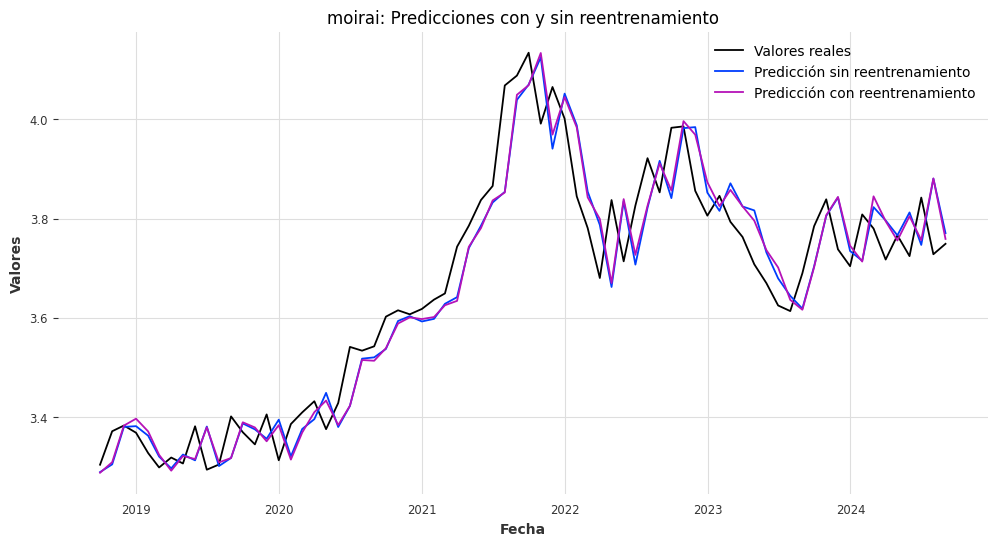

In [157]:
# Visualizar resultados
plt.figure(figsize=(12, 6))
plt.plot(test.time_index, y_true, label="Valores reales")
plt.plot(test.time_index, y_pred_no_retrain, label="Predicción sin reentrenamiento")
plt.plot(test.time_index, y_pred_with_retrain, label="Predicción con reentrenamiento")
plt.legend()
plt.title("moirai: Predicciones con y sin reentrenamiento")
plt.xlabel("Fecha")
plt.ylabel("Valores")
plt.show()

In [158]:
# Implementar estrategia de trading
real_returns = return_series(test.pd_series())
pred_returns_no_retrain = return_series(moirai_forecast_no_retrain_unscaled.pd_series())
pred_returns_with_retrain = return_series(
    moirai_forecast_with_retrain_unscaled.pd_series()
)

In [159]:
# Implementar estrategia de trading para ambos casos
strategy_returns_no_retrain = implement_trading_strategy(
    real_returns, pred_returns_no_retrain
)
strategy_returns_with_retrain = implement_trading_strategy(
    real_returns, pred_returns_with_retrain
)

In [160]:
# Calcular retornos acumulados
cumulative_real = calculate_cumulative_return(real_returns)
cumulative_strategy_no_retrain = calculate_cumulative_return(
    strategy_returns_no_retrain
)
cumulative_strategy_with_retrain = calculate_cumulative_return(
    strategy_returns_with_retrain
)

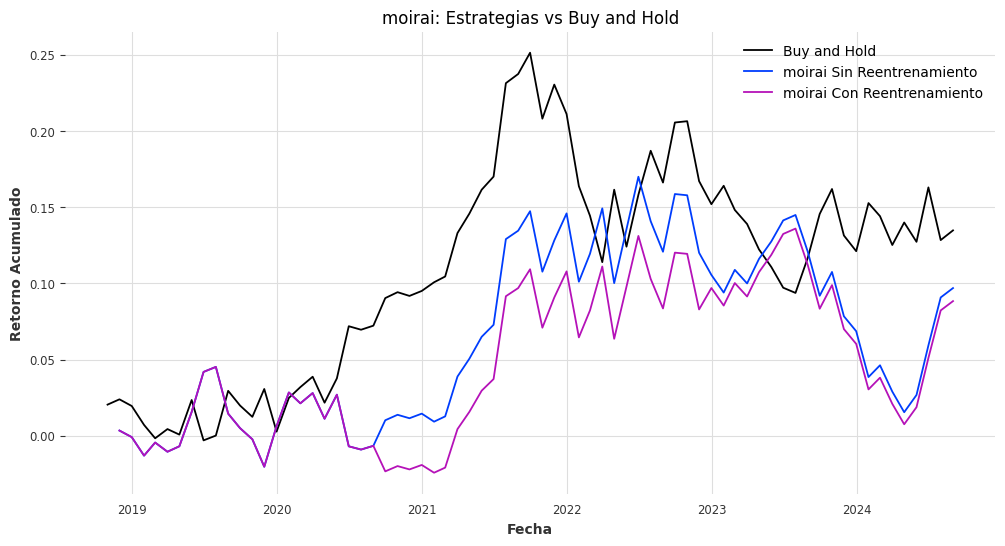

In [161]:
# Visualizar resultados de la estrategia
plt.figure(figsize=(12, 6))
plt.plot(cumulative_real.index, cumulative_real, label="Buy and Hold")
plt.plot(
    cumulative_strategy_no_retrain.index,
    cumulative_strategy_no_retrain,
    label="moirai Sin Reentrenamiento",
)
plt.plot(
    cumulative_strategy_with_retrain.index,
    cumulative_strategy_with_retrain,
    label="moirai Con Reentrenamiento",
)
plt.legend()
plt.title("moirai: Estrategias vs Buy and Hold")
plt.xlabel("Fecha")
plt.ylabel("Retorno Acumulado")
plt.show()

In [162]:
# Calcular métricas de rendimiento
metrics_buy_hold = calculate_all_metrics(real_returns)
metrics_strategy_no_retrain = calculate_all_metrics(
    strategy_returns_no_retrain, real_returns
)
metrics_strategy_with_retrain = calculate_all_metrics(
    strategy_returns_with_retrain, real_returns
)

print("\nMétricas de rendimiento:")
print("\nBuy and Hold:")
for k, v in metrics_buy_hold.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia moirai sin reentrenamiento:")
for k, v in metrics_strategy_no_retrain.items():
    print(f"{k}: {v:.4f}")
print("\nEstrategia moirai con reentrenamiento:")
for k, v in metrics_strategy_with_retrain.items():
    print(f"{k}: {v:.4f}")


Métricas de rendimiento:

Buy and Hold:
Total Return: 0.1348
Annualized Return: 0.0216
Sharpe Ratio: 0.3437
Information Ratio: 0.0992
Max Drawdown: -0.1260
Hit Ratio: 100.0000

Estrategia moirai sin reentrenamiento:
Total Return: 0.0969
Annualized Return: 0.0158
Sharpe Ratio: 0.2635
Information Ratio: -0.0072
Max Drawdown: -0.1321
Hit Ratio: 56.3380

Estrategia moirai con reentrenamiento:
Total Return: 0.0884
Annualized Return: 0.0144
Sharpe Ratio: 0.2440
Information Ratio: -0.0112
Max Drawdown: -0.1130
Hit Ratio: 53.5211


In [163]:
# Guardar métricas finales para comparación de modelos
moirai_metrics_no_retrain, moirai_returns_no_retrain = evaluate_model_performance(
    y_true, y_pred_no_retrain, "MOIRAI", retrain=False
)
moirai_metrics_with_retrain, moirai_returns_with_retrain = evaluate_model_performance(
    y_true, y_pred_with_retrain, "MOIRAI", retrain=True
)